In [1]:
import time
from typing import List, Dict
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import machine_learning_modules as ml
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the clean data

In [3]:
df = ml.read_csv("filtered_df.csv")
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [4]:
# shufle the data into validation and Training data
# Training data is further split into training and test for used during model development
# Validaton is used to assess and evaluate the best model performance.
# Split the data into training and test sets

target_feature = 'Default'
random_state = 42
models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(max_iter=1000),
    # LinearDiscriminantAnalysis(),
    # SVC()
]
cv = 10
test_size = 0.35 # default value is 0.2
columns_to_remove = ['LoanID']
random_state = 43
balance_technique = 'oversampling'
    
trained_df, validate_df = ml.shuffle_and_split(df, target_feature, test_size, random_state, columns_to_remove)

In [5]:
trained_df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
197666,53,102418,21289,840,56,4,21.04,24,0.20,Bachelor's,Unemployed,Divorced,Yes,Yes,Other,No,0
255120,61,116055,162409,554,86,2,21.70,36,0.47,Bachelor's,Part-time,Single,No,No,Auto,No,0
143813,29,86592,184776,615,24,4,10.66,24,0.15,PhD,Full-time,Divorced,Yes,Yes,Education,No,0
173623,28,58387,100677,372,39,3,19.39,24,0.15,Master's,Self-employed,Single,No,No,Home,Yes,0
51106,26,105362,135192,644,13,1,22.82,60,0.25,Bachelor's,Self-employed,Married,No,No,Other,Yes,1


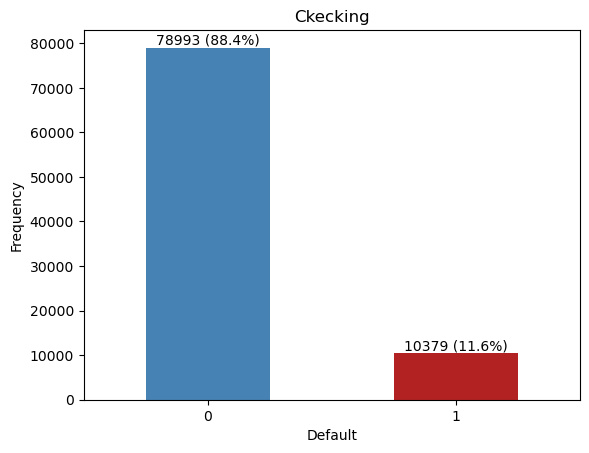

In [6]:
ml.checking_class_dist(validate_df, 'Default', 'Ckecking')

In [13]:
results_df, transformed_feature_names = ml.train_models(trained_df, target_feature, models, balance_technique, test_size, cv)
results_df

Best model RandomForestClassifier saved to best_model_RandomForestClassifier.joblib


,Model,Mean CV Accuracy,CV Accuracy Std,Accuracy,Precision,Recall,F1-Score,Confusion Matrix,Best Model
0,DecisionTreeClassifier,0.915652,0.002295,0.925213,0.934019,0.925213,0.924831,"[[43848, 7497], [183, 51163]]",False
1,RandomForestClassifier,0.979146,0.001304,0.985422,0.985650,0.985422,0.985421,"[[50041, 1304], [193, 51153]]",True
2,LogisticRegression,0.683186,0.004385,0.683760,0.683798,0.683760,0.683744,"[[34737, 16608], [15867, 35479]]",False


### Loading the best model

In [15]:
prefixes = ['cat_', 'num_']
new_column_names = ml.remove_prefixes(list(transformed_feature_names), prefixes)

Model loaded from best_model_RandomForestClassifier.joblib
Model loaded from preprocessor.joblib


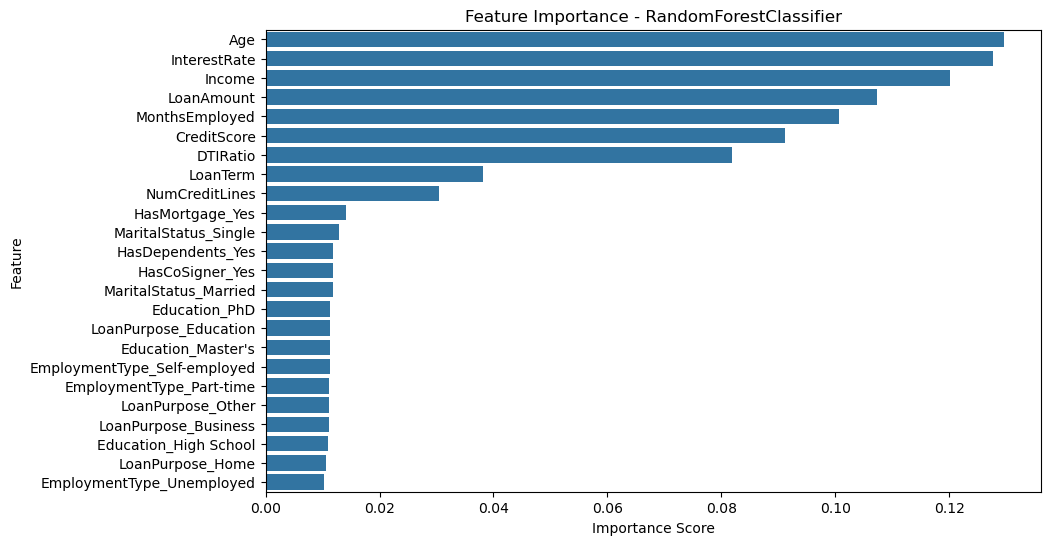

In [16]:
# Load the best model and the Preprocessor
loaded_model = ml.load_model_artifact("best_model_RandomForestClassifier.joblib")
preprocessor = ml.load_model_artifact("preprocessor.joblib")

# Extract feature importances
feature_importances = loaded_model.feature_importances_

# Create a DataFrame to visualize feature importance
importance_df = pd.DataFrame({
    'Feature': new_column_names,
    'Importance': feature_importances
})


# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df = importance_df[importance_df['Importance'] != 0]

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - RandomForestClassifier')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

### Testing Performance on Unseen Data

In [19]:
validate_df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
73807,47,126370,150872,413,17,1,13.46,48,0.33,PhD,Full-time,Divorced,No,Yes,Education,Yes,1
40819,49,136317,188465,529,62,2,8.90,48,0.89,High School,Unemployed,Single,No,Yes,Home,Yes,0
50370,21,125473,244307,468,58,3,2.83,48,0.41,Bachelor's,Unemployed,Single,Yes,Yes,Business,Yes,0
26271,69,46838,49503,735,50,4,23.09,60,0.47,PhD,Self-employed,Single,No,No,Business,No,0
97792,39,92321,213626,359,63,1,8.74,60,0.61,PhD,Full-time,Single,No,No,Business,Yes,0


In [20]:
X = validate_df.drop(columns=[target_feature])
y_val = validate_df[target_feature]
X_val = preprocessor.transform(X)

In [21]:
ml.evaluate_model_on_validation_set(loaded_model, X_val, y_val)

Validation Performance:
Accuracy: 0.8791
Precision: 0.8447
Recall: 0.8791
F1-Score: 0.8526
Confusion Matrix:
[[76951  2042]
 [ 8766  1613]]


Text(0.5, 23.52222222222222, 'Predicted label')

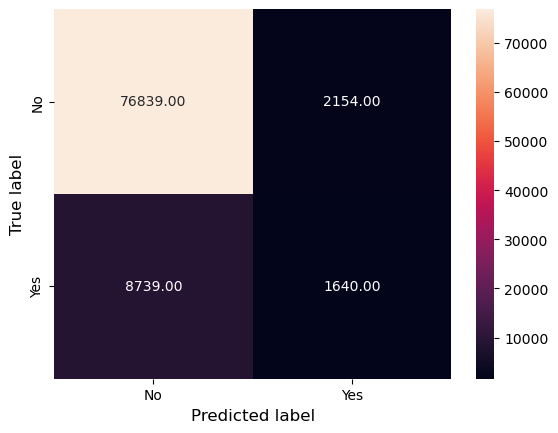

In [22]:
cm = [[76839, 2154], [ 8739 , 1640]]
sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["No", "Yes"] , yticklabels = ["No", "Yes"],)
plt.ylabel('True label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)

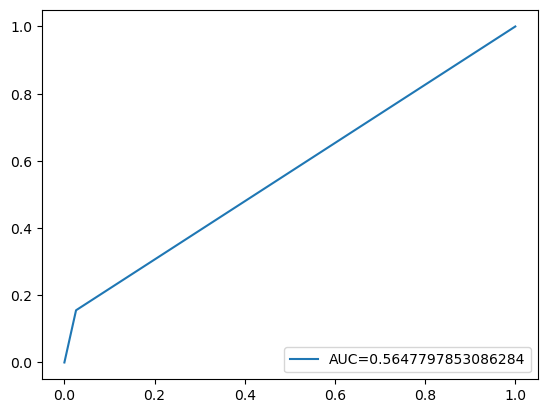

In [23]:
from sklearn import metrics
#define metrics
y_pred_proba = loaded_model.predict(X_val)
y_val = validate_df[target_feature]
#y_test_binary = y_test.replace({'N': 0, 'Y': 1})
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()